## Testing notebook

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import os
import seaborn as sns
from sklearn.preprocessing import normalize
import pyreadr
import igraph as ig

In [5]:
PATH = '../data/'

## Age and Sex Analysis

In [6]:
number_of_rows = 16
properties = pd.DataFrame({
    'Age': list(range(1, 9)) * 2,
    'sex': [None] * number_of_rows,
    'nodes': [None] * number_of_rows,
    'degree': [None] * number_of_rows,
    'avg_path_length': [None] * number_of_rows,
    'betweenness': [None] * number_of_rows,
    'centrality': [None] * number_of_rows,
    'closeness': [None] * number_of_rows,
    'density': [None] * number_of_rows,
    'modularity': [None] * number_of_rows
    
})

In [7]:
def normalize_matrix(OR_mat):
    # Loop over each row and normalize by row sums, avoiding division by zero
    for i in range(OR_mat.shape[0]):
        row_sum = OR_mat[i, :].sum()
        if row_sum > 0:
            OR_mat[i, :] = OR_mat[i, :] / row_sum
    return OR_mat

In [16]:
ii=0
for age in range(1, 9):
    # Load adjacency matrix for males
    result = pyreadr.read_r(PATH+f"3.AdjacencyMatrices/Adj_Matrix_Male_ICD_age_{age}.rds")
    OR = result[None].values
    
    # Normalize adjacency matrix using the R-like method
    OR_normalized =  normalize_matrix(OR.copy())

    # Create graph from adjacency matrix using igraph
    graph = ig.Graph.Weighted_Adjacency(OR_normalized.tolist(), mode="max", attr="weight")

 

    non_zero_nodes = np.where((OR.sum(axis=0) != 0) | (OR.sum(axis=1) != 0))[0]
    properties.at[ii, 'nodes'] = len(non_zero_nodes)

    # Calculate the degree (number of non-zero entries in each row/column) and then average degree for non-zero degree nodes
    row_sums = (OR != 0).sum(axis=1)  # Calculate the number of non-zero entries per row
    non_zero_degrees = row_sums[row_sums != 0]  # Filter out rows with 0 degree
    properties.at[ii, 'degree'] = np.mean(non_zero_degrees)

   
    shortest_paths = graph.distances()
    
    # Flatten the list of shortest paths, ignore infinity, and calculate the mean
    finite_lengths = [length for sublist in shortest_paths for length in sublist if length < float('inf')]
    if len(finite_lengths) > 0:
        avg_path_length = np.mean(finite_lengths)
    else:
        avg_path_length = float('nan')  # No paths in the graph

    properties.at[ii, 'avg_path_length'] = avg_path_length
    if graph.is_connected():
        #properties.at[ii, 'avg_path_length'] = graph.average_path_length(directed=False)
        closeness = graph.closeness(normalized=True)
    else:
        # Use only the largest connected component
        largest_cc = graph.connected_components().giant()
        #properties.at[ii, 'avg_path_length'] = largest_cc.average_path_length(directed = False)
        closeness = largest_cc.closeness(normalized=True)

        # Assign 0 for disconnected nodes (outside largest connected component)
        disconnected_nodes = set(range(graph.vcount())) - set(largest_cc.vs.indices)
        closeness = list(closeness) + [0] * len(disconnected_nodes)

    # Betweenness centrality
    betweenness = graph.betweenness()
    properties.at[ii, 'betweenness'] = np.mean(betweenness)

    # Closeness centrality
    closeness = graph.closeness(normalized=True)

    # Handle disconnected nodes by setting their closeness to 0
    closeness_values = [v if not np.isinf(v) else 0 for v in closeness]
    properties.at[ii, 'closeness'] = np.nanmean(closeness_values)

    # Density
    properties.at[ii, 'density'] = graph.density()

    # Modularity
    communities = graph.community_multilevel()
    properties.at[ii, 'modularity'] = graph.modularity(communities)

    properties.at[ii, 'sex'] = "Male"
    
    ii += 1

In [18]:
for age in range(1, 9):
    # Load adjacency matrix for males
    result = pyreadr.read_r(PATH+f"3.AdjacencyMatrices/Adj_Matrix_Female_ICD_age_{age}.rds")
    OR = result[None].values
    
    # Normalize adjacency matrix using the R-like method
    OR_normalized =  normalize_matrix(OR.copy())

    # Create graph from adjacency matrix using igraph
    graph = ig.Graph.Weighted_Adjacency(OR_normalized.tolist(), mode="max", attr="weight")

 

    non_zero_nodes = np.where((OR.sum(axis=0) != 0) | (OR.sum(axis=1) != 0))[0]
    properties.at[ii, 'nodes'] = len(non_zero_nodes)

    # Calculate the degree (number of non-zero entries in each row/column) and then average degree for non-zero degree nodes
    row_sums = (OR != 0).sum(axis=1)  # Calculate the number of non-zero entries per row
    non_zero_degrees = row_sums[row_sums != 0]  # Filter out rows with 0 degree
    properties.at[ii, 'degree'] = np.mean(non_zero_degrees)

   
    shortest_paths = graph.distances()
    
    # Flatten the list of shortest paths, ignore infinity, and calculate the mean
    finite_lengths = [length for sublist in shortest_paths for length in sublist if length < float('inf')]
    if len(finite_lengths) > 0:
        avg_path_length = np.mean(finite_lengths)
    else:
        avg_path_length = float('nan')  # No paths in the graph

    properties.at[ii, 'avg_path_length'] = avg_path_length
    if graph.is_connected():
        #properties.at[ii, 'avg_path_length'] = graph.average_path_length(directed=False)
        closeness = graph.closeness(normalized=True)
    else:
        # Use only the largest connected component
        largest_cc = graph.connected_components().giant()
        #properties.at[ii, 'avg_path_length'] = largest_cc.average_path_length(directed = False)
        closeness = largest_cc.closeness(normalized=True)

        # Assign 0 for disconnected nodes (outside largest connected component)
        disconnected_nodes = set(range(graph.vcount())) - set(largest_cc.vs.indices)
        closeness = list(closeness) + [0] * len(disconnected_nodes)

    # Betweenness centrality
    betweenness = graph.betweenness()
    properties.at[ii, 'betweenness'] = np.mean(betweenness)

    # Closeness centrality
    closeness = graph.closeness(normalized=True)

    # Handle disconnected nodes by setting their closeness to 0
    closeness_values = [v if not np.isinf(v) else 0 for v in closeness]
    properties.at[ii, 'closeness'] = np.nanmean(closeness_values)

    # Density
    properties.at[ii, 'density'] = graph.density()

    # Modularity
    communities = graph.community_multilevel()
    properties.at[ii, 'modularity'] = graph.modularity(communities)

    properties.at[ii, 'sex'] = "Female"
    
    ii += 1

In [19]:
custom_col = ["#A6CEE3", "#1F78B4", "#B2DF8A", "#33A02C", "#FB9A99", "#E31A1C",
              "#FDBF6F", "#FF7F00", "#CAB2D6", "#6A3D9A", "#FFFF99", "#B15928"]

custom_labels = ["0-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79"]
plt.rcParams['font.size'] = 16


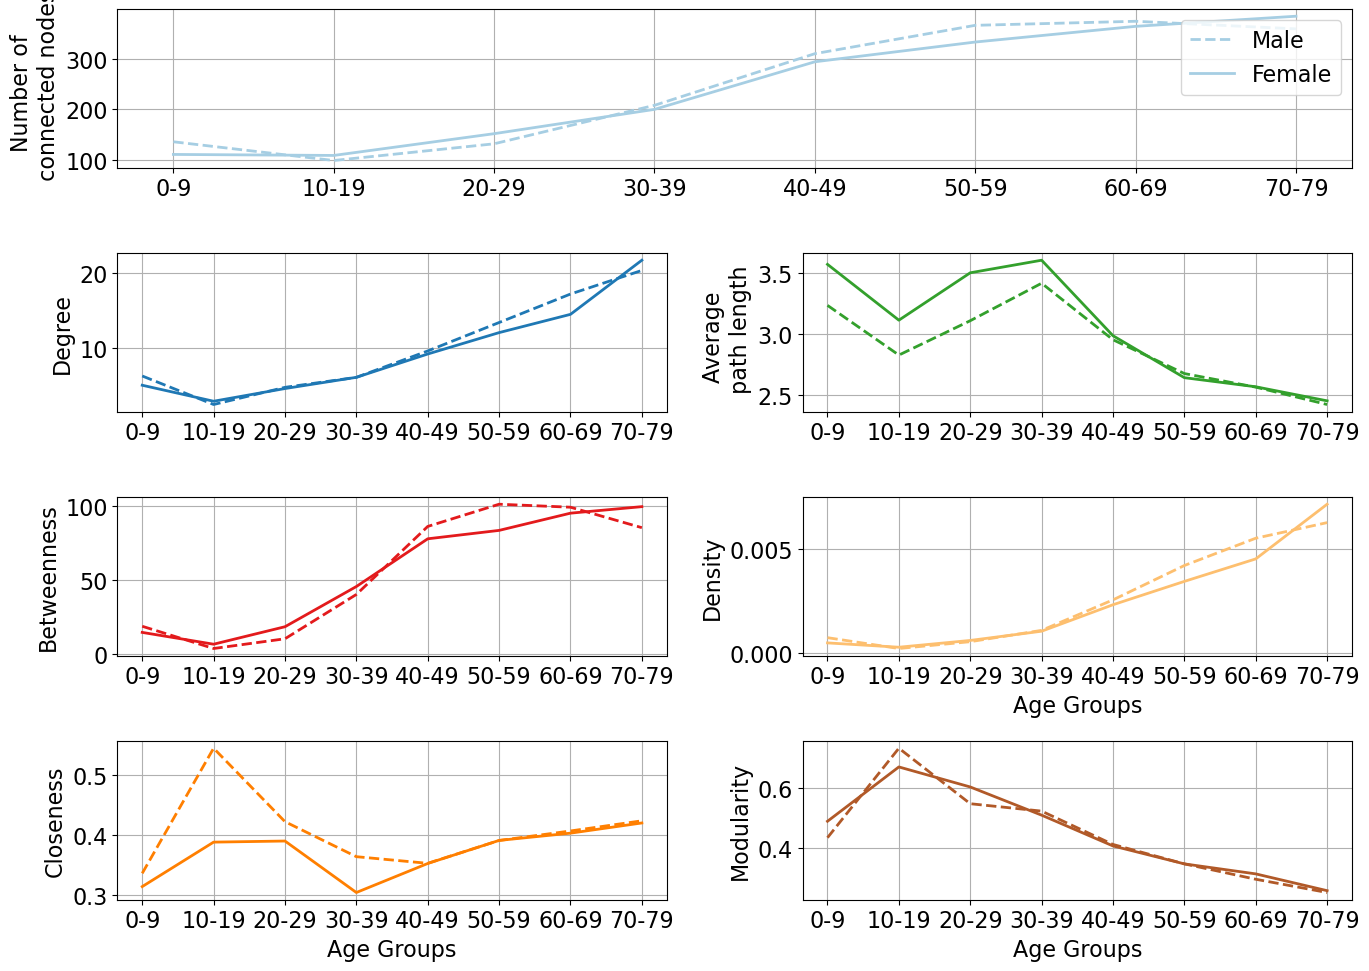

In [21]:
fig = plt.figure(figsize=(14, 10))   
gs = fig.add_gridspec(4, 2)   

# Plot 0: Number of connected nodes  
ax0 = fig.add_subplot(gs[0, :])
ax0.plot(properties['Age'][properties['sex'] == 'Male'], properties['nodes'][properties['sex'] == 'Male'], label='Male', color=custom_col[0], linewidth=2, linestyle='--')
ax0.plot(properties['Age'][properties['sex'] == 'Female'], properties['nodes'][properties['sex'] == 'Female'], label='Female', color=custom_col[0], linewidth=2, linestyle='-')
ax0.set_ylabel("Number of \n connected nodes")
ax0.set_xlabel("")
ax0.set_xticks(range(1, 9))
ax0.set_xticklabels(custom_labels)
ax0.grid(True)
ax0.legend(loc="upper right")

# Plot 1: Degree  
ax1 = fig.add_subplot(gs[1, 0])
ax1.plot(properties['Age'][properties['sex'] == 'Male'], properties['degree'][properties['sex'] == 'Male'], label='Male', color=custom_col[1], linewidth=2, linestyle='--')
ax1.plot(properties['Age'][properties['sex'] == 'Female'], properties['degree'][properties['sex'] == 'Female'], label='Female', color=custom_col[1], linewidth=2, linestyle='-')
ax1.set_ylabel("Degree")
ax1.set_xlabel("")
ax1.set_xticks(range(1, 9))
ax1.set_xticklabels(custom_labels)
ax1.grid(True)

# Plot 2: Average Path Length  
ax2 = fig.add_subplot(gs[1, 1])
ax2.plot(properties['Age'][properties['sex'] == 'Male'], properties['avg_path_length'][properties['sex'] == 'Male'], label='Male', color=custom_col[3], linewidth=2, linestyle='--')
ax2.plot(properties['Age'][properties['sex'] == 'Female'], properties['avg_path_length'][properties['sex'] == 'Female'], label='Female', color=custom_col[3], linewidth=2, linestyle='-')
ax2.set_ylabel("Average \n path length")
ax2.set_xlabel("")
ax2.set_xticks(range(1, 9))
ax2.set_xticklabels(custom_labels)
ax2.grid(True)

# Plot 3: Betweenness  
ax3 = fig.add_subplot(gs[2, 0])
ax3.plot(properties['Age'][properties['sex'] == 'Male'], properties['betweenness'][properties['sex'] == 'Male'], label='Male', color=custom_col[5], linewidth=2, linestyle='--')
ax3.plot(properties['Age'][properties['sex'] == 'Female'], properties['betweenness'][properties['sex'] == 'Female'], label='Female', color=custom_col[5], linewidth=2, linestyle='-')
ax3.set_ylabel("Betweenness")
ax3.set_xlabel("")
ax3.set_xticks(range(1, 9))
ax3.set_xticklabels(custom_labels)
ax3.grid(True)

# Plot 4: Density 
ax4 = fig.add_subplot(gs[2, 1])
ax4.plot(properties['Age'][properties['sex'] == 'Male'], properties['density'][properties['sex'] == 'Male'], label='Male', color=custom_col[6], linewidth=2, linestyle='--')
ax4.plot(properties['Age'][properties['sex'] == 'Female'], properties['density'][properties['sex'] == 'Female'], label='Female', color=custom_col[6], linewidth=2, linestyle='-')
ax4.set_ylabel("Density")
ax4.set_xlabel("Age Groups")
ax4.set_xticks(range(1, 9))
ax4.set_xticklabels(custom_labels)
ax4.grid(True)

# Plot 5: Closeness  
ax5 = fig.add_subplot(gs[3, 0])
ax5.plot(properties['Age'][properties['sex'] == 'Male'], properties['closeness'][properties['sex'] == 'Male'], label='Male', color=custom_col[7], linewidth=2, linestyle='--')
ax5.plot(properties['Age'][properties['sex'] == 'Female'], properties['closeness'][properties['sex'] == 'Female'], label='Female', color=custom_col[7], linewidth=2, linestyle='-')
ax5.set_ylabel("Closeness")
ax5.set_xlabel("Age Groups")
ax5.set_xticks(range(1, 9))
ax5.set_xticklabels(custom_labels)
ax5.grid(True)

# Plot 6: Modularity  
ax6 = fig.add_subplot(gs[3, 1])
ax6.plot(properties['Age'][properties['sex'] == 'Male'], properties['modularity'][properties['sex'] == 'Male'], label='Male', color=custom_col[11], linewidth=2, linestyle='--')
ax6.plot(properties['Age'][properties['sex'] == 'Female'], properties['modularity'][properties['sex'] == 'Female'], label='Female', color=custom_col[11], linewidth=2, linestyle='-')
ax6.set_ylabel("Modularity")
ax6.set_xlabel("Age Groups")
ax6.set_xticks(range(1, 9))
ax6.set_xticklabels(custom_labels)
ax6.grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()